In [2]:
%matplotlib inline
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageDraw as imd

im = cv.imread(r'C:\Users\user\Downloads\rocks.jpg')

In [3]:
# function to return true or false when the number is a perfect square, to indicate the 
# shape of the filter as circle or ellipse
def is_int (num):
    num =np.sqrt(num)
    if (abs(num)%2==0 or (abs(num)+1)%2==0):
        return True
    else :
        return False

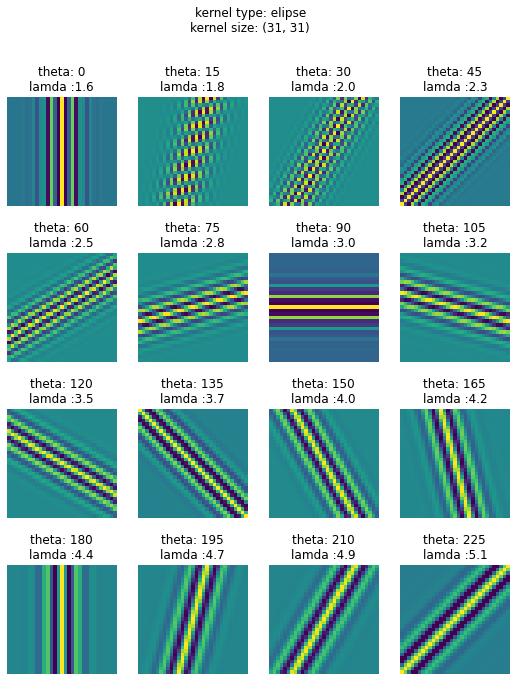

In [4]:
# function to construct the kernels, for given kernel size,gamma and lamda type
#returns figure and kernels as list, kernel type (circle/ellipse),thetas, lamdas and type(fixed/variable)
def kernel_builder(k=11,gamma=1,lamda='var'):
    
    if k%2==0:
        k=k+1
    if is_int(gamma):
        kernel_type ='circle'
    else:
        kernel_type= 'elipse'
    
    #thetas =np.full(16,np.pi)
    thetas=np.arange(0, 5*np.pi/4, np.pi/12)
    
    if lamda=='var':
        lamdas = np.linspace(np.pi/2, np.pi+2, 16)    
    else :
        lamdas = np.full(16,lamda)
    
    f,ax =plt.subplots(4,4, figsize=(9,11))
    
    kernels =[]
      
    for lam,theta,axs in zip(lamdas,thetas, ax.flatten()):
        kern = cv.getGaborKernel((k,k), sigma=4.0, theta=theta, lambd=lam,psi=0,gamma=gamma, ktype=cv.CV_32F)
        kernels.append(kern)
               
        axs.imshow(kern)
        axs.set_title('theta: {:.0f}\nlamda :{:.1f}'.format(theta*180/np.pi,lam))
        axs.axis('off')

    f.suptitle('kernel type: {}\nkernel size: {}'.format(kernel_type,(k,k)))
    f.set_tight_layout(False)
    #f.savefig(fname =r'C:\Users\user\Documents\kernels_{}_{}_lamda_{}.png'.format(k,kernel_type,lamda),format= 'png')
    return f,kernels,kernel_type,thetas,lamdas,lamda,gamma

figure, kernels,k_type,thetas,lamdas,l_type,gamma = kernel_builder(k=31,gamma=0.01)

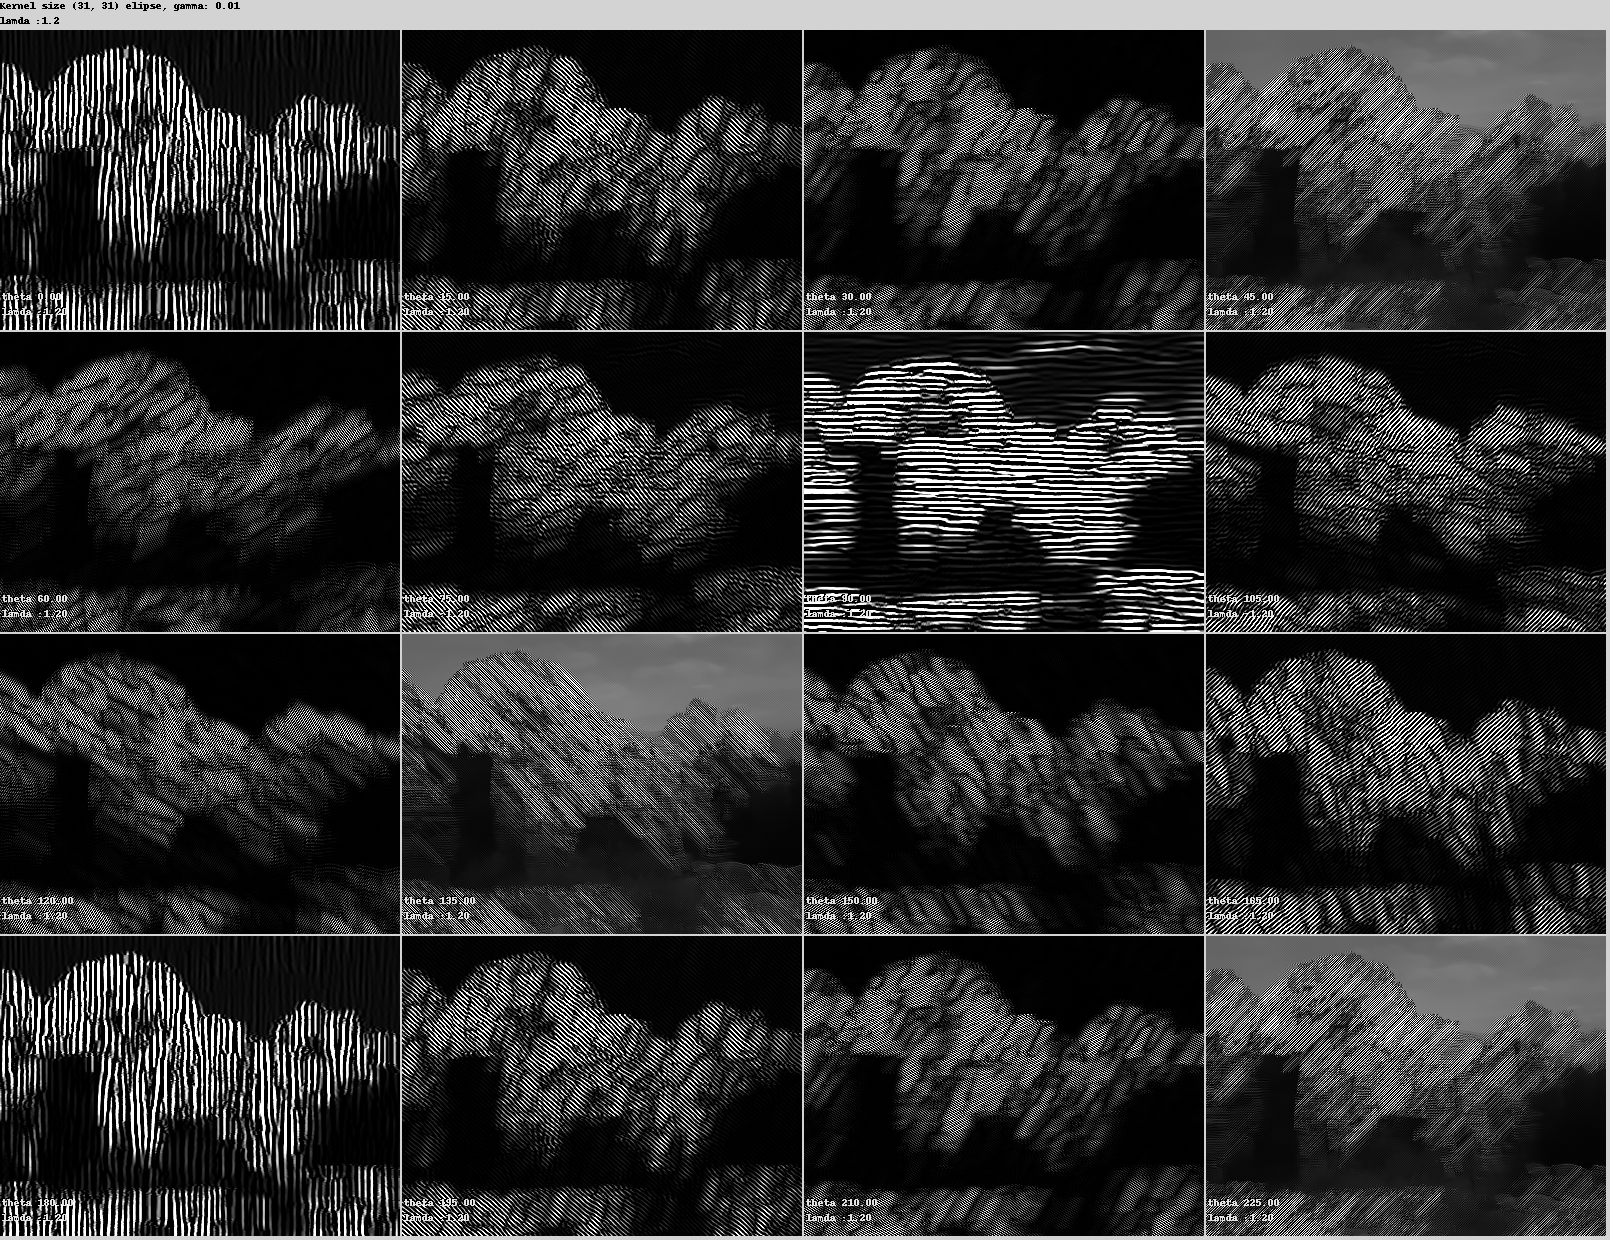

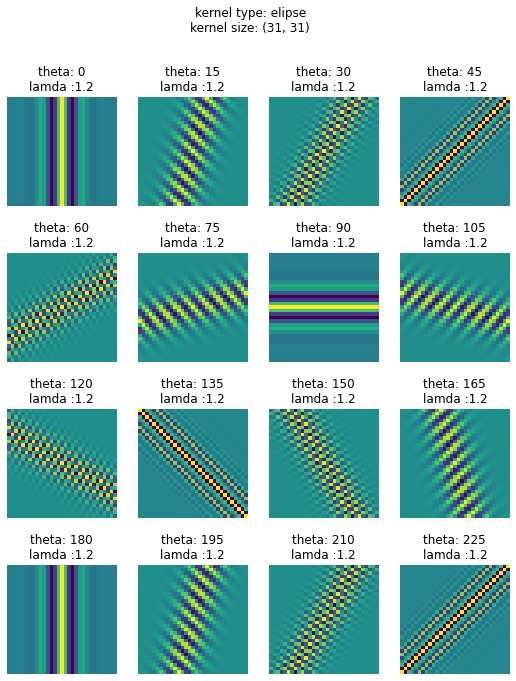

In [5]:
def apply_kernels(im,kernels,k_type,thetas,lamdas,l_type,gamma):
    
    from PIL import ImageDraw as imd
    from PIL import Image
    import cv2 as cv
    
    #pre-processing to converting to gray scale image and denoising images before applying filter
    im = cv.resize(im,(400,300), cv.INTER_AREA)
    height,width = im.shape[0],im.shape[1]
    gray = cv.cvtColor(im,cv.COLOR_BGR2GRAY)
    dst = cv.fastNlMeansDenoising(gray,None,10,7,21)
    filtered_im = []
    canvas = Image.new('L', (4*width+10,4*height+40),'lightgray')
    x,y =0,30
    k=kernels[0].shape[0]
    imd.Draw(canvas).text((0,0),'Kernel size {} {}, gamma: {} \nlamda :{}'.format((k,k),k_type,gamma,l_type), 
                            fill='black', stroke_width=0,stroke_fill='black')
    
    #applying convolution kernel filters on the image
    for kernel,teta,lamda in zip(kernels,thetas,lamdas):
        fimg = cv.filter2D(dst, cv.CV_8UC3, kernel)
        filtered_im.append(fimg)
        fimg = Image.fromarray(fimg)
        imd.Draw(fimg).text((1,fimg.height-40),'theta {:.2f}\nlamda :{:.2f}'.format(teta*180/np.pi,lamda), 
                            fill='yellow', stroke_width=1,stroke_fill='black')
        canvas.paste(fimg,(x,y))
        if (x+fimg.width)>4*width:
            x = 0
            y = y + fimg.height + 2
            
        else: x = x + fimg.width + 2
        
        canvas.save(r'C:\Users\user\Documents\gallery_{}_{}_lamda_{}_gama_{}.png'.format(k_type,k,l_type,gamma),format='png')
    return canvas, filtered_im
#im = cv.imread(r'C:\Users\user\Downloads\gallery.jpg')
figure, kernels,k_type,thetas,lamdas,lamda_type,gamma = kernel_builder(k=31,gamma=0.01,lamda =1.2)
cvas,filts = apply_kernels(im,kernels,k_type,thetas,lamdas,lamda_type,gamma)
cvas

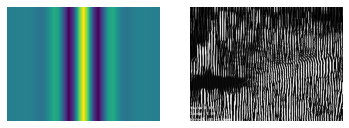

In [6]:
def display_kernel_filter(im,k=7,theta=0,lamda=0,gamma=1):
    '''displays the kernel and the filtered image side by side'''
    from PIL import ImageDraw as imd
    from PIL import Image
    import cv2 as cv
    
    f,axes = plt.subplots(1,2, figsize=(6,6))
    axes = axes.flatten()
    axes[0].axis('off')
    theta=theta*np.pi/180
    
    #constructing kernel for our parameters
    kern = cv.getGaborKernel((k,k), sigma=4.0, theta=theta, lambd=lamda,psi=0,gamma=gamma, ktype=cv.CV_32F)
    axes[0].imshow(cv.resize(kern,(400,300),cv.INTER_AREA))
    
    #preprocessing images by shrinking,converting to grayscale and denoissing
    im = cv.resize(im,(400,300), cv.INTER_AREA)
    gray = cv.cvtColor(im,cv.COLOR_BGR2GRAY)
    dst = cv.fastNlMeansDenoising(gray,None,10,7,21)
    
    #applying convolution kernel on image
    fimg = cv.filter2D(dst, cv.CV_8UC3, kern)
    fimg = Image.fromarray(fimg)
    imd.Draw(fimg).text((1,fimg.height-40),'theta {:.2f}\nlamda :{:.2f}\nkernel :{} ellipse'.format(theta*180/np.pi,lamda,k),
                        fill='yellow', stroke_width=0,stroke_fill='black')
    axes[1].imshow(fimg, cmap='gray')
    axes[1].axis('off')
    #f.savefig(r'C:\Users\user\Documents\rocks_filtered.png',format='png')
    return f

im = cv.imread(r'C:\Users\user\Downloads\gallery.jpg')
img = display_kernel_filter(im,k=31,theta=0,lamda=1.2,gamma=0)

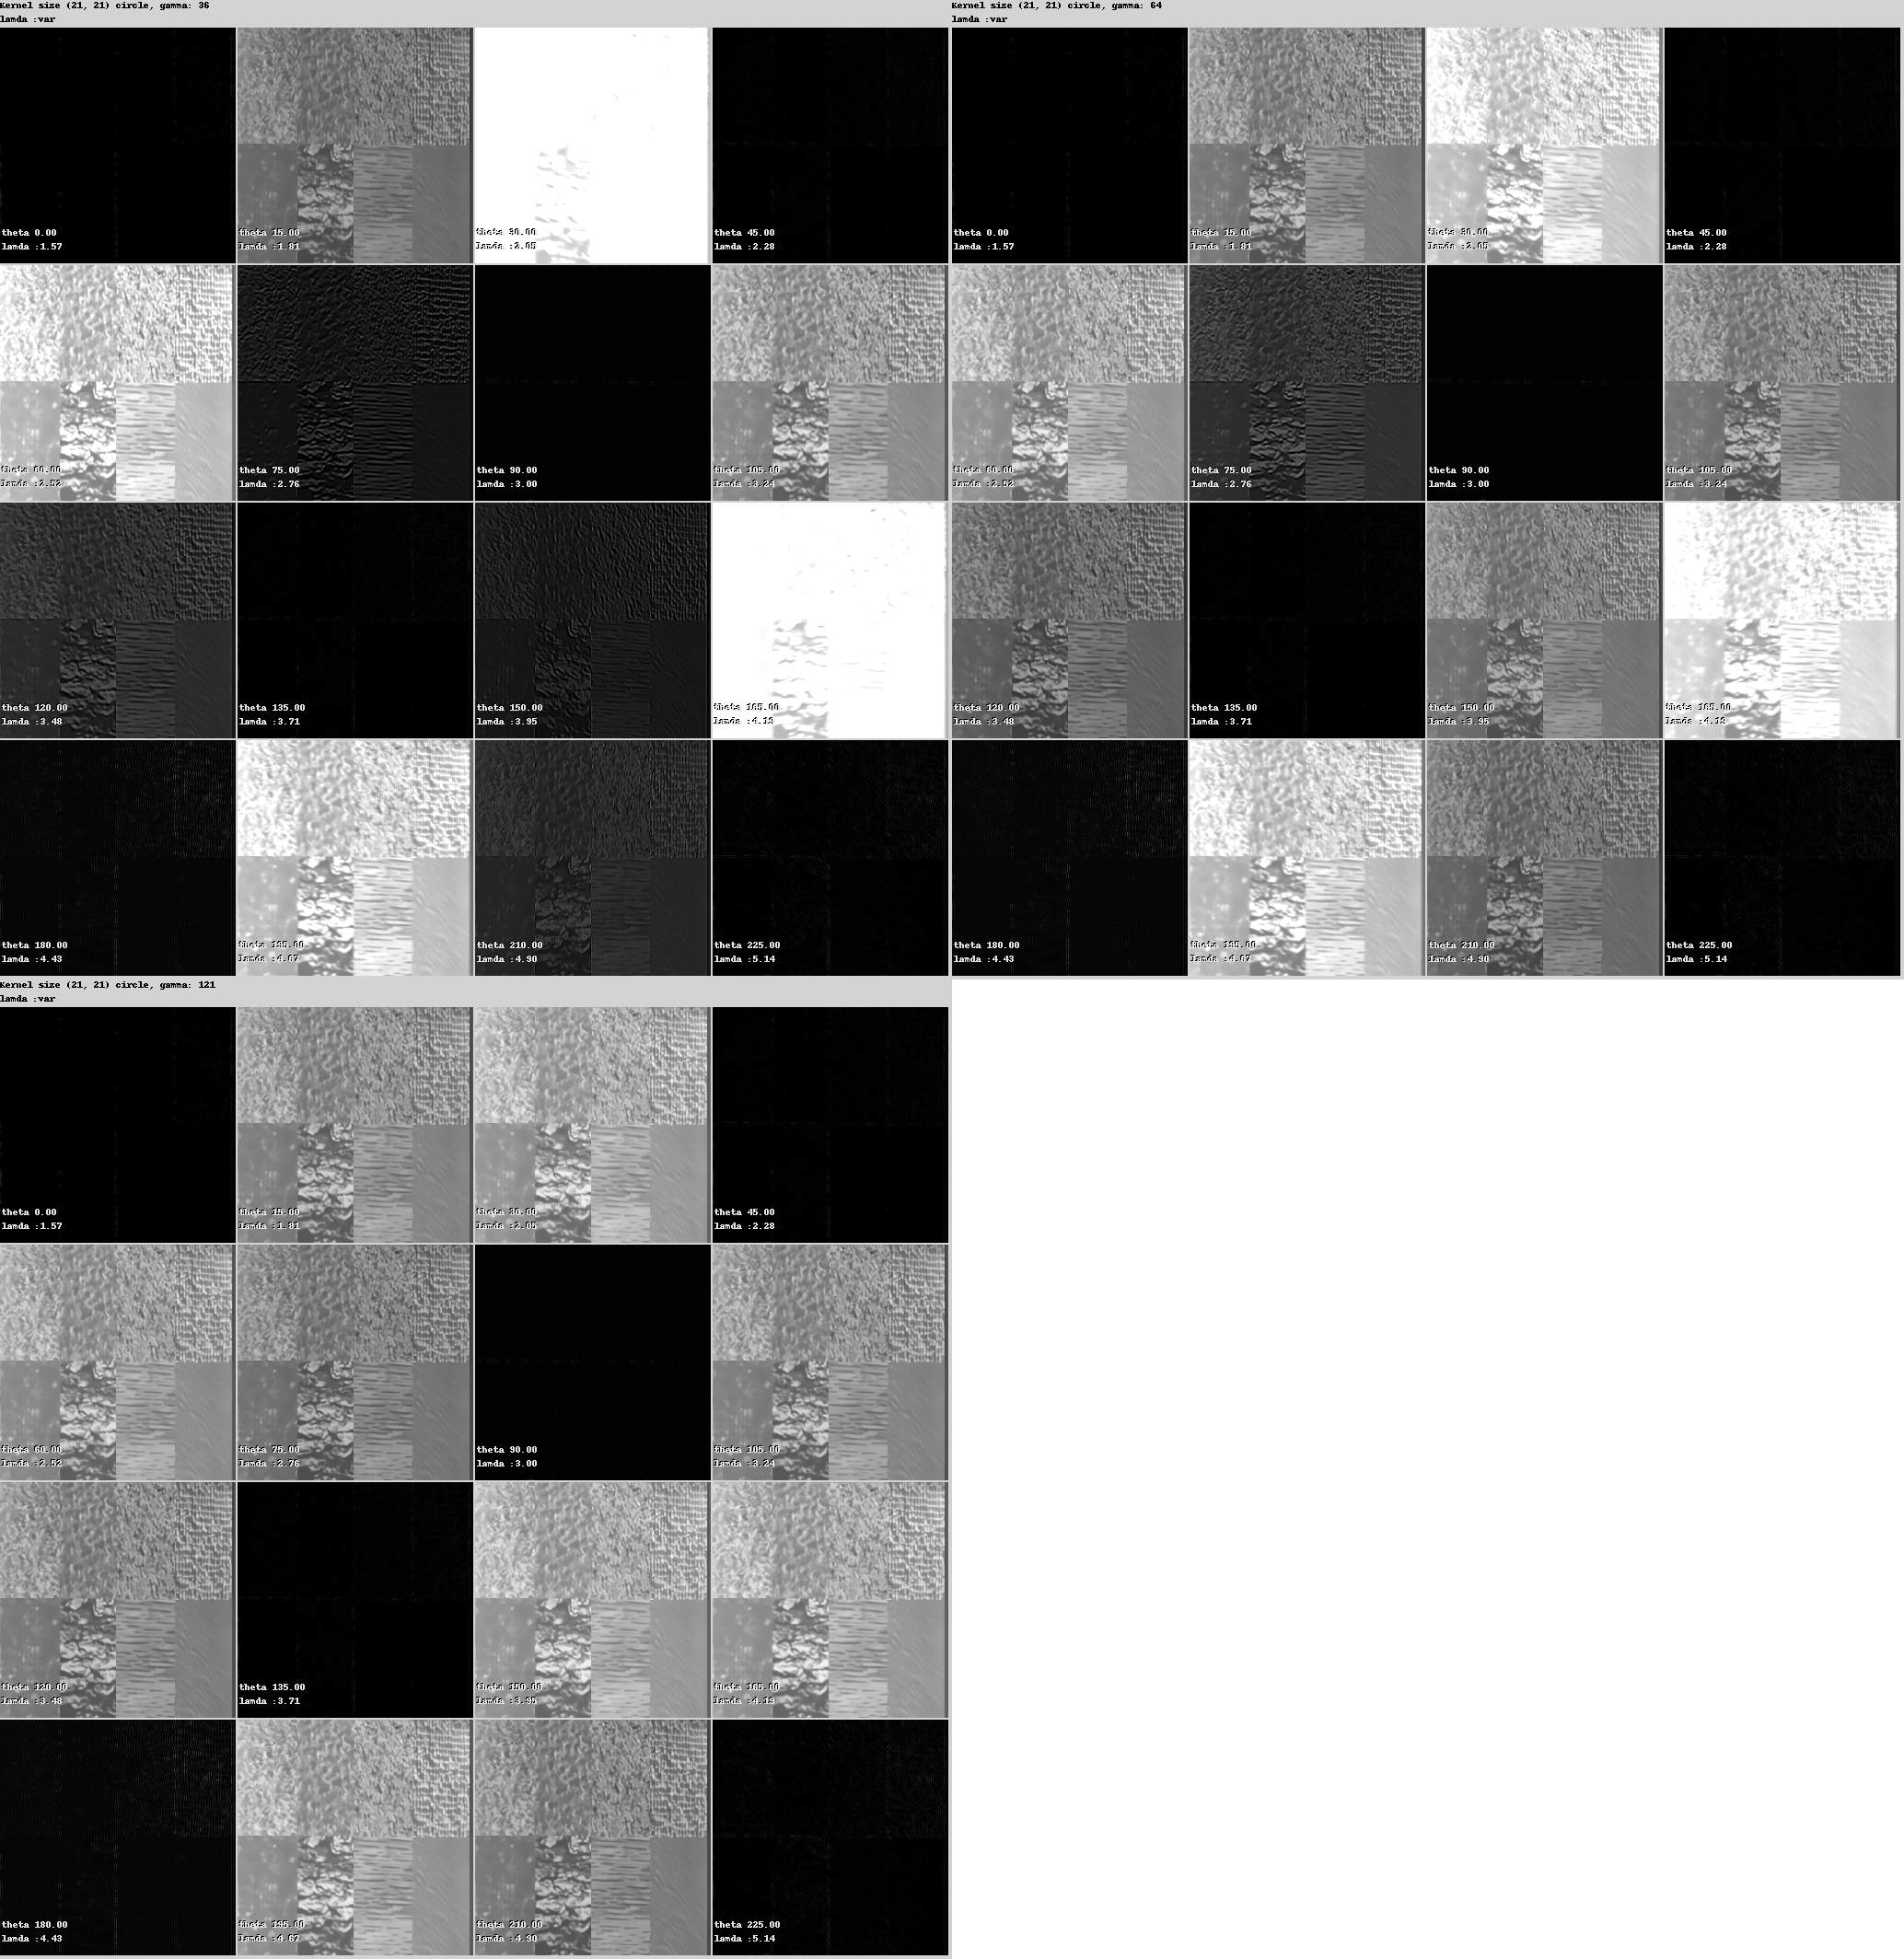

In [7]:
def print_canvas(im, reduction,cols,rows):
    
    width = im[0].reduce(reduction).width
    height = im[0].reduce(reduction).height
    sheet = Image.new('RGB', (width*cols,height*rows),'white')
    x =0
    y = 0
    
    for img in im:
        sheet.paste(img.reduce(reduction),(x,y))
        x = x+width
        if x > width:
            x=0
            y+=height


    sheet
    #sheet.save(r'C:\Users\user\Documents\gama_compare.png',format='png')
    return sheet

names = ['combine_circle_21_lamda_var_gama_36.png','combine_circle_21_lamda_var_gama_64.png','combine_circle_21_lamda_var_gama_121.png']
path = r'C:\Users\user\Documents'
im = [Image.open(path + '\{}'.format(i)) for i in names]

print_canvas(im,1,2,2)